<a href="https://colab.research.google.com/github/abhishek2602/Projects/blob/master/Adiction_Probability_Incedo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

Using TensorFlow backend.


In [0]:
def get_data():
    #get train data
    train_data_path ='train_file.csv'
    train = pd.read_csv(train_data_path)
    
    #get test data
    test_data_path ='test_file.csv'
    test = pd.read_csv(test_data_path)

    return train , test

def get_combined_data():
    #reading train data
    train , test = get_data()

    target = train.Greater_Risk_Probability
    train.drop(['Greater_Risk_Probability'], axis = 1, inplace = True)

    combined = train.append(test)
    combined.reset_index(inplace = True)
    combined.drop(['Patient_ID', 'LocationDesc', 'Greater_Risk_Question', 'Description', 'GeoLocation', 'index'], inplace = True, axis = 1)
    return combined, target

#Load train and test data into pandas DataFrames
train_data, test_data = get_data()

#Combine train and test data to process them together
combined, target = get_combined_data()

In [0]:
combined.head()

,YEAR,Subtopic,Sample_Size,Sex,Race,Grade,QuestionCode,StratID1,StratID2,StratID3,StratificationType
0,1995,1,335.0,Female,Hispanic or Latino,4,H49,1,4,0,Local
1,1997,0,382.0,Total,Black or African American,4,H42,0,3,0,Local
2,1993,0,196.0,Female,White,0,H41,1,6,2,State
3,2017,1,104.0,Male,Asian,4,H49,2,2,0,State
4,2007,1,100.0,Female,Multiple Race,4,H55,1,7,0,Local


In [0]:
combined.shape

(92331, 11)

In [0]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92331 entries, 0 to 92330
Data columns (total 11 columns):
YEAR                  92331 non-null int64
Subtopic              92331 non-null int64
Sample_Size           92331 non-null float64
Sex                   92331 non-null object
Race                  92331 non-null object
Grade                 92331 non-null int64
QuestionCode          92331 non-null object
StratID1              92331 non-null int64
StratID2              92331 non-null int64
StratID3              92331 non-null int64
StratificationType    92331 non-null object
dtypes: float64(1), int64(6), object(4)
memory usage: 7.7+ MB


In [0]:
combined.describe()

,YEAR,Subtopic,Sample_Size,Grade,StratID1,StratID2,StratID3
count,92331.000000,92331.000000,92331.000000,92331.000000,92331.000000,92331.000000,92331.000000
mean,2007.692617,0.748384,565.225959,2.238793,0.894564,2.726170,1.705213
std,6.913335,0.433944,1138.970546,1.494852,0.825567,2.520042,1.446622
min,1991.000000,0.000000,50.000000,0.000000,0.000000,0.000000,0.000000
25%,2003.000000,0.000000,166.000000,1.000000,0.000000,0.000000,0.000000
50%,2009.000000,1.000000,276.000000,2.000000,1.000000,3.000000,2.000000
75%,2013.000000,1.000000,560.000000,4.000000,2.000000,6.000000,3.000000
max,2017.000000,1.000000,53664.000000,4.000000,2.000000,7.000000,4.000000


In [0]:
def get_cols_with_no_nans(df, col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [0]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

In [0]:
print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 7
Number of nun-numerical columns with no nan values : 4


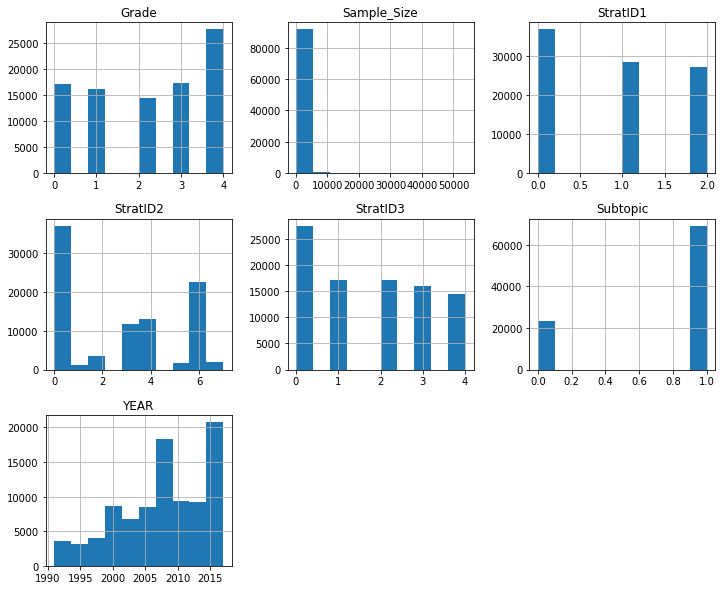

In [0]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

In [0]:
dummies_num_col = ['Grade', 'StratID1', 'StratID2', 'StratID3', 'Subtopic', 'YEAR']

In [0]:
for col in dummies_num_col:
    dummies = pd.get_dummies(combined[col], prefix = col)
    combined = pd.concat([combined, dummies], axis = 1)
    combined.drop(col, axis = 1, inplace = True)

In [0]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 42 columns before encoding categorical features
There are 74 columns after encoding categorical features


In [0]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms.fit(combined)
combined = mms.transform(combined)

In [0]:
def split_combined():
    global combined
    train = combined[:55399]
    test = combined[55399:]

    return train , test 
  
train, test = split_combined()

In [0]:
train.shape

(55399, 74)

In [0]:
NN_model = Sequential()

# The Input Layer
NN_model.add(Dense(128, kernel_initializer = 'normal', input_dim = train.shape[1], activation = 'relu'))

# The Hidden Layer
NN_model.add(Dense(256, kernel_initializer = 'normal', activation = 'relu'))
NN_model.add(Dense(256, kernel_initializer = 'normal', activation = 'relu'))
NN_model.add(Dense(256, kernel_initializer = 'normal', activation = 'relu'))

# The Output Layer
NN_model.add(Dense(1, kernel_initializer = 'normal', activation = 'linear'))

# Complie the network
NN_model.compile(loss = 'mean_absolute_error', optimizer = 'adam', metrics = ['mse'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               9600      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 174,465
Trainable params: 174,465
Non-trainable params: 0
_________________________________________________________________


In [0]:
NN_model.fit(train, target, epochs = 500, batch_size = 32, validation_split = 0.2)

Train on 44319 samples, validate on 11080 samples
Epoch 1/500
44319/44319 [==============================] - 5s 107us/step - loss: 5.4687 - mean_squared_error: 71.0300 - val_loss: 4.4731 - val_mean_squared_error: 41.6440
Epoch 2/500
44319/44319 [==============================] - 5s 102us/step - loss: 4.4366 - mean_squared_error: 39.4793 - val_loss: 4.3114 - val_mean_squared_error: 38.1777
Epoch 3/500
44319/44319 [==============================] - 4s 97us/step - loss: 4.3322 - mean_squared_error: 37.9583 - val_loss: 4.3319 - val_mean_squared_error: 38.8916
Epoch 4/500
44319/44319 [==============================] - 4s 94us/step - loss: 4.2282 - mean_squared_error: 36.6106 - val_loss: 4.2596 - val_mean_squared_error: 37.8098
Epoch 5/500
44319/44319 [==============================] - 4s 94us/step - loss: 4.1812 - mean_squared_error: 35.8290 - val_loss: 4.2495 - val_mean_squared_error: 37.7812
Epoch 6/500
44319/44319 [==============================] - 4s 93us/step - loss: 4.1411 - mean_squa

Epoch 49/500
44319/44319 [==============================] - 4s 99us/step - loss: 3.3684 - mean_squared_error: 25.5342 - val_loss: 4.4592 - val_mean_squared_error: 41.5374
Epoch 50/500
44319/44319 [==============================] - 4s 97us/step - loss: 3.3600 - mean_squared_error: 25.4005 - val_loss: 4.2811 - val_mean_squared_error: 38.4536
Epoch 51/500
44319/44319 [==============================] - 4s 93us/step - loss: 3.3445 - mean_squared_error: 25.2947 - val_loss: 4.2893 - val_mean_squared_error: 38.4991
Epoch 52/500
44319/44319 [==============================] - 4s 92us/step - loss: 3.3345 - mean_squared_error: 25.1697 - val_loss: 4.2703 - val_mean_squared_error: 38.4495
Epoch 53/500
44319/44319 [==============================] - 4s 93us/step - loss: 3.3266 - mean_squared_error: 24.9771 - val_loss: 4.3347 - val_mean_squared_error: 39.6444
Epoch 54/500
44319/44319 [==============================] - 4s 93us/step - loss: 3.3304 - mean_squared_error: 25.0694 - val_loss: 4.3156 - val_me

Epoch 97/500
44319/44319 [==============================] - 4s 91us/step - loss: 3.0093 - mean_squared_error: 21.8754 - val_loss: 4.4227 - val_mean_squared_error: 40.5811
Epoch 98/500
44319/44319 [==============================] - 4s 94us/step - loss: 3.0055 - mean_squared_error: 21.8522 - val_loss: 4.4400 - val_mean_squared_error: 41.2010
Epoch 99/500
44319/44319 [==============================] - 4s 96us/step - loss: 2.9989 - mean_squared_error: 21.7727 - val_loss: 4.4211 - val_mean_squared_error: 40.6194
Epoch 100/500
44319/44319 [==============================] - 4s 94us/step - loss: 3.0043 - mean_squared_error: 21.7738 - val_loss: 4.4303 - val_mean_squared_error: 40.6230
Epoch 101/500
44319/44319 [==============================] - 4s 93us/step - loss: 2.9926 - mean_squared_error: 21.7349 - val_loss: 4.4663 - val_mean_squared_error: 40.9180
Epoch 102/500
44319/44319 [==============================] - 4s 92us/step - loss: 2.9881 - mean_squared_error: 21.6554 - val_loss: 4.4854 - val

44319/44319 [==============================] - 4s 94us/step - loss: 2.8219 - mean_squared_error: 20.1833 - val_loss: 4.5380 - val_mean_squared_error: 42.9176
Epoch 145/500
44319/44319 [==============================] - 4s 93us/step - loss: 2.8182 - mean_squared_error: 20.1595 - val_loss: 4.5947 - val_mean_squared_error: 43.7256
Epoch 146/500
44319/44319 [==============================] - 4s 92us/step - loss: 2.8147 - mean_squared_error: 20.1309 - val_loss: 4.5059 - val_mean_squared_error: 42.0298
Epoch 147/500
44319/44319 [==============================] - 4s 93us/step - loss: 2.8123 - mean_squared_error: 20.0848 - val_loss: 4.5295 - val_mean_squared_error: 42.2971
Epoch 148/500
44319/44319 [==============================] - 4s 96us/step - loss: 2.8106 - mean_squared_error: 20.0507 - val_loss: 4.5099 - val_mean_squared_error: 42.3029
Epoch 149/500
44319/44319 [==============================] - 4s 97us/step - loss: 2.8060 - mean_squared_error: 20.0331 - val_loss: 4.5163 - val_mean_squar

Epoch 192/500
44319/44319 [==============================] - 4s 98us/step - loss: 2.6866 - mean_squared_error: 19.0883 - val_loss: 4.6260 - val_mean_squared_error: 43.2721
Epoch 193/500
44319/44319 [==============================] - 4s 94us/step - loss: 2.6838 - mean_squared_error: 19.0846 - val_loss: 4.5739 - val_mean_squared_error: 43.1440
Epoch 194/500
44319/44319 [==============================] - 4s 93us/step - loss: 2.6771 - mean_squared_error: 18.9892 - val_loss: 4.5948 - val_mean_squared_error: 43.3723
Epoch 195/500
44319/44319 [==============================] - 4s 95us/step - loss: 2.6738 - mean_squared_error: 18.9681 - val_loss: 4.5606 - val_mean_squared_error: 42.6242
Epoch 196/500
44319/44319 [==============================] - 4s 94us/step - loss: 2.6794 - mean_squared_error: 19.0073 - val_loss: 4.5788 - val_mean_squared_error: 42.8655
Epoch 197/500
44319/44319 [==============================] - 4s 94us/step - loss: 2.6734 - mean_squared_error: 18.9965 - val_loss: 4.5593 - 

44319/44319 [==============================] - 4s 94us/step - loss: 2.5817 - mean_squared_error: 18.1906 - val_loss: 4.6320 - val_mean_squared_error: 44.0840
Epoch 240/500
44319/44319 [==============================] - 4s 94us/step - loss: 2.5759 - mean_squared_error: 18.1744 - val_loss: 4.6231 - val_mean_squared_error: 43.8869
Epoch 241/500
44319/44319 [==============================] - 4s 92us/step - loss: 2.5825 - mean_squared_error: 18.2340 - val_loss: 4.6187 - val_mean_squared_error: 43.8407
Epoch 242/500
44319/44319 [==============================] - 4s 92us/step - loss: 2.5718 - mean_squared_error: 18.1425 - val_loss: 4.6656 - val_mean_squared_error: 44.7471
Epoch 243/500
44319/44319 [==============================] - 4s 92us/step - loss: 2.5722 - mean_squared_error: 18.1429 - val_loss: 4.6146 - val_mean_squared_error: 43.6571
Epoch 244/500
44319/44319 [==============================] - 4s 92us/step - loss: 2.5730 - mean_squared_error: 18.0994 - val_loss: 4.6223 - val_mean_squar

Epoch 287/500
44319/44319 [==============================] - 4s 92us/step - loss: 2.5005 - mean_squared_error: 17.6017 - val_loss: 4.6430 - val_mean_squared_error: 44.0085
Epoch 288/500
44319/44319 [==============================] - 4s 93us/step - loss: 2.4942 - mean_squared_error: 17.5661 - val_loss: 4.6522 - val_mean_squared_error: 44.6360
Epoch 289/500
44319/44319 [==============================] - 4s 92us/step - loss: 2.4879 - mean_squared_error: 17.5008 - val_loss: 4.6831 - val_mean_squared_error: 44.9652
Epoch 290/500
44319/44319 [==============================] - 4s 92us/step - loss: 2.4943 - mean_squared_error: 17.5002 - val_loss: 4.6786 - val_mean_squared_error: 44.9355
Epoch 291/500
44319/44319 [==============================] - 4s 94us/step - loss: 2.4871 - mean_squared_error: 17.4481 - val_loss: 4.6824 - val_mean_squared_error: 45.1360
Epoch 292/500
44319/44319 [==============================] - 4s 94us/step - loss: 2.4917 - mean_squared_error: 17.6026 - val_loss: 4.6619 - 

44319/44319 [==============================] - 4s 88us/step - loss: 2.4272 - mean_squared_error: 17.0403 - val_loss: 4.6699 - val_mean_squared_error: 44.5225
Epoch 335/500
44319/44319 [==============================] - 4s 89us/step - loss: 2.4256 - mean_squared_error: 16.9975 - val_loss: 4.6688 - val_mean_squared_error: 44.7254
Epoch 336/500
44319/44319 [==============================] - 4s 89us/step - loss: 2.4246 - mean_squared_error: 17.0332 - val_loss: 4.6937 - val_mean_squared_error: 45.2610
Epoch 337/500
44319/44319 [==============================] - 4s 89us/step - loss: 2.4302 - mean_squared_error: 17.0099 - val_loss: 4.7116 - val_mean_squared_error: 45.1044
Epoch 338/500
44319/44319 [==============================] - 4s 89us/step - loss: 2.4284 - mean_squared_error: 17.0440 - val_loss: 4.7035 - val_mean_squared_error: 45.0764
Epoch 339/500
44319/44319 [==============================] - 4s 91us/step - loss: 2.4245 - mean_squared_error: 16.9690 - val_loss: 4.7009 - val_mean_squar

Epoch 382/500
44319/44319 [==============================] - 4s 89us/step - loss: 2.3707 - mean_squared_error: 16.5938 - val_loss: 4.7281 - val_mean_squared_error: 45.7222
Epoch 383/500
44319/44319 [==============================] - 4s 89us/step - loss: 2.3694 - mean_squared_error: 16.5363 - val_loss: 4.6924 - val_mean_squared_error: 44.9371
Epoch 384/500
44319/44319 [==============================] - 4s 90us/step - loss: 2.3691 - mean_squared_error: 16.5472 - val_loss: 4.6858 - val_mean_squared_error: 45.1380
Epoch 385/500
44319/44319 [==============================] - 4s 89us/step - loss: 2.3597 - mean_squared_error: 16.5161 - val_loss: 4.7125 - val_mean_squared_error: 45.6944
Epoch 386/500
44319/44319 [==============================] - 4s 89us/step - loss: 2.3630 - mean_squared_error: 16.5544 - val_loss: 4.6847 - val_mean_squared_error: 45.1539
Epoch 387/500
44319/44319 [==============================] - 4s 88us/step - loss: 2.3685 - mean_squared_error: 16.5457 - val_loss: 4.7340 - 

44319/44319 [==============================] - 4s 88us/step - loss: 2.3168 - mean_squared_error: 16.1638 - val_loss: 4.7303 - val_mean_squared_error: 45.8002
Epoch 430/500
44319/44319 [==============================] - 4s 89us/step - loss: 2.3157 - mean_squared_error: 16.1253 - val_loss: 4.7347 - val_mean_squared_error: 45.7302
Epoch 431/500
44319/44319 [==============================] - 4s 90us/step - loss: 2.3168 - mean_squared_error: 16.1499 - val_loss: 4.7486 - val_mean_squared_error: 46.0123
Epoch 432/500
44319/44319 [==============================] - 4s 89us/step - loss: 2.3164 - mean_squared_error: 16.1754 - val_loss: 4.7701 - val_mean_squared_error: 46.4656
Epoch 433/500
44319/44319 [==============================] - 4s 89us/step - loss: 2.3088 - mean_squared_error: 16.1092 - val_loss: 4.7387 - val_mean_squared_error: 45.9027
Epoch 434/500
44319/44319 [==============================] - 4s 89us/step - loss: 2.3073 - mean_squared_error: 16.0825 - val_loss: 4.7547 - val_mean_squar

Epoch 477/500
44319/44319 [==============================] - 4s 91us/step - loss: 2.2664 - mean_squared_error: 15.7523 - val_loss: 4.7298 - val_mean_squared_error: 45.5823
Epoch 478/500
44319/44319 [==============================] - 4s 90us/step - loss: 2.2718 - mean_squared_error: 15.7810 - val_loss: 4.7354 - val_mean_squared_error: 45.9028
Epoch 479/500
44319/44319 [==============================] - 4s 90us/step - loss: 2.2646 - mean_squared_error: 15.6823 - val_loss: 4.7324 - val_mean_squared_error: 45.8407
Epoch 480/500
44319/44319 [==============================] - 4s 92us/step - loss: 2.2627 - mean_squared_error: 15.7248 - val_loss: 4.7438 - val_mean_squared_error: 45.6322
Epoch 481/500
44319/44319 [==============================] - 4s 91us/step - loss: 2.2640 - mean_squared_error: 15.7382 - val_loss: 4.7753 - val_mean_squared_error: 46.7330
Epoch 482/500
44319/44319 [==============================] - 4s 90us/step - loss: 2.2628 - mean_squared_error: 15.7300 - val_loss: 4.7589 - 

In [0]:
def make_submission(prediction, sub_name):
    my_submission = pd.DataFrame({'Patient_ID': pd.read_csv('test_file.csv').Patient_ID, 'Greater_Risk_Probability': prediction})
    my_submission.to_csv('{}.csv'.format(sub_name), index = False)
    print('A submission file has been made')

predictions = NN_model.predict(test)
make_submission(predictions[:,0], 'submission(NN).csv')

A submission file has been made
